In [5]:
import torch
import torchvision
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchmetrics
from PIL import Image
from tqdm import tqdm
from data.guided_diffusion.unet import create_model
from src.utils import *
from src.h_fcn import *
from src.pigdm import PIGDM
from src.eval import *
import time

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda:0


In [2]:
# Here let's consider a toy example, we won't look at the results but just at the inference time for each models
# Due to resource constraints, we won't do a lot of run

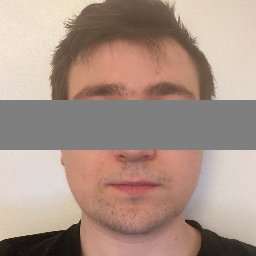

In [11]:
model = init_model()

imgshape = (1, 3, 256, 256)

img_pil = Image.open('../data/knt.png')
x_true = pilimg_to_tensor(img_pil)


mask = torch.eye(256, device=device)
mask[100:150] = 0
l = x_true.shape[2]-x_true.shape[3]
x = F.interpolate(x_true[:,:,l//2-100:-l//2-100,20:], size=(256, 256), mode='bilinear', align_corners=False)
# i redimentionned it so my face is well centered

H = Linear(mask)
y = H(x)
display_as_pilimg(y[:,:])


pgdm = PIGDM(model, 256, H, num_ddim_steps=400, eta=0.2)


Sampling:   0%|          | 0/399 [00:00<?, ?it/s]

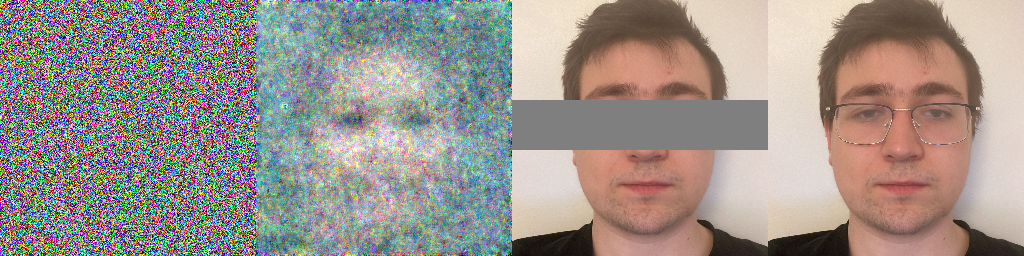

Sampling:  50%|█████     | 200/399 [00:46<00:46,  4.27it/s]

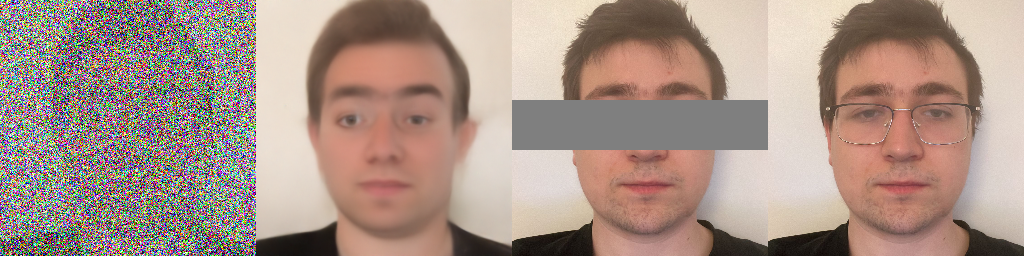

Sampling: 100%|██████████| 399/399 [01:33<00:00,  4.25it/s]


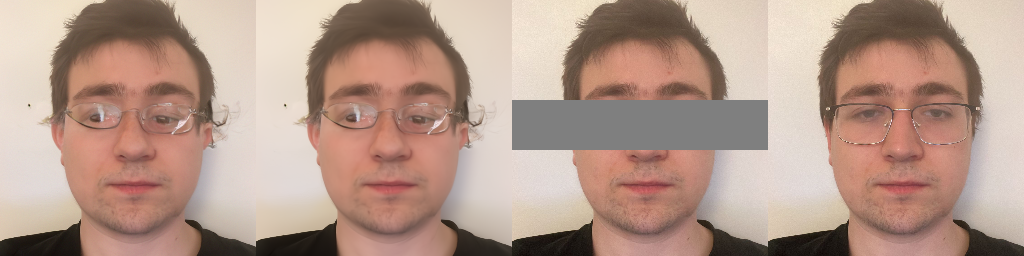

Temps d'exécution : 93.8517 secondes


In [12]:
start_time = time.time()
_ = pgdm.posterior_sampling(y, x_true=x, show_steps=True, vis_y=None, steps_viz=200)
end_time = time.time()

execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.4f} secondes")

In [ ]:
# the cell above was just an example, ofc we need to put verbose on off if we want a fair comparison

# It is better to take the average time over severall run but here we will simply do one shot for each

# scenario

In [18]:
list_ddim_steps = [10, 50, 100, 400, 1000]

results = {}

for n_ddim in tqdm(list_ddim_steps):
    results[n_ddim] = []

    pgdm = PIGDM(model, 256, H, num_ddim_steps=n_ddim, eta=0.2)

    start_time = time.time()
    _ = pgdm.posterior_sampling(y, x_true=x, show_steps=False, vis_y=None, steps_viz=200,  tqdm_bar=False)
    end_time = time.time()

    results[n_ddim].append(end_time-start_time)

    ddim = DDIM(model, num_ddim_steps=n_ddim)


    start_time = time.time()
    _ = ddim.posterior_sampling(linear_operator=H, y=y, x_true=x, show_steps=False, vis_y=None, eta=0.2, steps_viz=25)
    end_time = time.time()

    results[n_ddim].append(end_time-start_time)


  0%|          | 0/5 [00:00<?, ?it/s]/home/onyxia/work/Generative_Modeling_Project/src/pigdm.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_s = torch.tensor(self.alphas_cp_torch[si].cpu() if si != -1 else 1.0,
 80%|████████  | 4/5 [11:47<02:56, 176.95s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.53 GiB of which 1.75 MiB is free. Process 2750523 has 4.50 GiB memory in use. Process 2842862 has 4.75 GiB memory in use. Process 681768 has 5.26 GiB memory in use. Of the allocated memory 4.36 GiB is allocated by PyTorch, and 791.66 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
results # run out of memory for cuda

{10: [2.080482006072998, 2.1516051292419434],
 50: [11.307678937911987, 11.202629566192627],
 100: [23.007193326950073, 22.807466983795166],
 400: [93.89169406890869, 93.63577651977539],
 1000: [237.4056453704834]}